# UNet 

Código de la red basada en: https://github.com/zhixuhao/unet

## Importar paquetes necesarios

In [ ]:
import matplotlib.pyplot as plt
from skimage import data,io,color
from skimage.filters import threshold_otsu,median,gaussian
import numpy as np
from tensorflow_addons.image.distance_transform import euclidean_dist_transform
from tensorflow.image import convert_image_dtype
import tensorflow as tf
from sklearn.model_selection import (StratifiedShuffleSplit,GridSearchCV,ShuffleSplit)
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             confusion_matrix, f1_score)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch.utils.data import Dataset, DataLoader, Subset

import cv2
from sklearn.neighbors import NearestNeighbors
import os
from PIL import Image
import glob

from subprocess import getoutput
import gc
from torch.utils.data import Dataset, DataLoader, Subset

In [ ]:
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.metrics import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

### Habilitar GPU on Colab
Es necesario habilitar el entorno de GPU 

Navegar a Editar-Configuración del cuaderno

Seleccionar GPU

In [ ]:
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not available. CPU training will be too slow.")

print("device name:", torch.cuda.get_device_name(0))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


En caso de que no se tenga descomprimido el archivo

In [ ]:
!unzip -uq "/content/drive/MyDrive/ImagenesVision/Bipbip.zip" -d "/content/drive/MyDrive/ImagenesVision/Bipbip"

Metrica de Jaccard o Intersección sobre Unión

In [ ]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = keras.sum(keras.abs(y_true * y_pred), axis=-1)
    sum_ = keras.sum(keras.abs(y_true) + keras.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

### Creación de la red UNet

In [ ]:
def unet2(pretrained_weights = None,input_size = (512,1024,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(2, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    metrics = [Precision(name="Precision"), 
                Recall(name="Recall"), "accuracy",jaccard_distance]
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = metrics)
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model


In [ ]:
model = unet2()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 1024, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 1024, 32 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 1024, 32 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 1024, 64 18496       conv2d_1[0][0]                   
_______________________________________________________________________________________

## Preparación de los Datos


In [ ]:
pathTrain = "/content/drive/MyDrive/ImagenesVision/Bipbip/Bipbip/Training/Haricot/Images"
pathMask = "/content/drive/MyDrive/ImagenesVision/Bipbip/Bipbip/Training/Haricot/Masks"

In [ ]:
#Almacena nombres de archivos
import os
files = [os.path.splitext(f)[0] for f in os.listdir(pathTrain) if f.endswith('.jpg')]# + [f for f in os.listdir(path) if f.endswith('.png')]

In [ ]:
img= Image.open(pathMask + '/' + files[6] + ".png") 
np_img = np.array(img) 
np_img.shape

(1536, 2048, 3)

In [ ]:
def maskData(files, path, datatype=float):
  masks = [0]*(4*len(files))
  for i, datafile in enumerate(files):
    img= np.array(Image.open(path + '/' + datafile + ".png"))[:,:,2]
    masks[4*i] = np.array([#(img<82).astype(datatype),
                          (img==255).astype(datatype),
                          (img==82).astype(datatype)]).transpose([0,2,1])[:,0:512,300:1324]
    masks[4*i+1] = np.array([#(img<82).astype(datatype),
                          (img==255).astype(datatype),
                          (img==82).astype(datatype)]).transpose([0,2,1])[:,512:1024,300:1324]
    masks[4*i+2] = np.array([#(img<82).astype(datatype),
                          (img==255).astype(datatype),
                          (img==82).astype(datatype)]).transpose([0,2,1])[:,1024:1536,300:1324]
    masks[4*i+3] = np.array([#(img<82).astype(datatype),
                          (img==255).astype(datatype),
                          (img==82).astype(datatype)]).transpose([0,2,1])[:,1536:2048,300:1324]
  return masks

In [ ]:
def ImageData(files, path):
  masks = [0]*(4*len(files))
  for i, datafile in enumerate(files):
    img= Image.open(path + '/' + datafile + ".jpg")
    masks[4*i] = np.array(img).transpose([1,0,2])[0:512,300:1324,:]/255
    masks[4*i+1] = np.array(img).transpose([1,0,2])[512:1024,300:1324,:]/255
    masks[4*i+2] = np.array(img).transpose([1,0,2])[1024:1536,300:1324,:]/255
    masks[4*i+3] = np.array(img).transpose([1,0,2])[1536:2048,300:1324,:]/255
  return masks

In [ ]:
idata = np.array(ImageData(files[:30], pathTrain))
mdata = np.array(maskData(files[:30], pathMask))

In [ ]:
mdata.shape, idata.shape

((120, 2, 512, 1024), (120, 512, 1024, 3))

In [ ]:
input_images, target_masks = idata, mdata
print("input_images shape and range", input_images.shape, input_images.min(), input_images.max())
print("target_masks shape and range", target_masks.shape, target_masks.min(), target_masks.max())

input_images shape and range (120, 512, 1024, 3) 0.0 1.0
target_masks shape and range (120, 2, 512, 1024) 0.0 1.0


In [ ]:
from functools import reduce
def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])

def plot_side_by_side(img_arrays):
    flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))

    plot_img_array(np.array(flatten_list), ncol=len(img_arrays))

In [ ]:
def convert_mask(data):
  mask2 = np.zeros((data.shape[0], data.shape[1], data.shape[2],3))
  for i, image in enumerate(data):
    mat1 = (data[i,:,:,0]>0.9)
    mat2 = (data[i,:,:,1]>0.9)
    for k in range(mat1.shape[0]):
      for l in range(mat1.shape[1]):
        if mat1[k,l]:
          mask2[i,k,l] = np.array([255,255,255])
        else:
          mask2[i,k,l] = np.array([0, 0 ,0])
        if mat2[k,l]:
          mask2[i,k,l] = np.array([216, 67, 82])
  return mask2/255

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class SimDataset(Dataset):
  def __init__(self, count, transform=None):
    self.input_images, self.target_masks = idata, mdata
    self.transform = transform

  def __len__(self):
    return len(self.input_images)

  def __getitem__(self, idx):
    image = self.input_images[idx]
    mask = self.target_masks[idx]
    if self.transform:
      image = self.transform(image)

    return [image, mask]

# use the same transformations for train/val in this example
trans = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

train_set = SimDataset(2000, transform = trans)
val_set = SimDataset(200, transform = trans)

image_datasets = {
  'train': train_set, 'val': val_set
}

batch_size = 32

dataloaders = {
  'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2),
  'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
}

In [ ]:
import torchvision.utils

def reverse_transform(inp):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  inp = (inp * 255).astype(np.uint8)

  return inp

def reverse_transform2(inp):
  inp = inp.numpy().transpose((1, 2, 0))
  return inp


torch.Size([32, 3, 512, 1024]) torch.Size([32, 2, 512, 1024])
float64 torch.Size([3, 512, 1024])
torch.float64


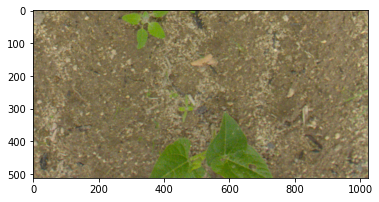

In [ ]:
# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))
inputs3, masks3 = next(iter(dataloaders['val']))
print(inputs.shape, masks.shape)

print(reverse_transform2(inputs[0]).dtype,inputs[0].shape)
print(inputs.dtype)
plt.imshow(reverse_transform(inputs[2]))

Los datos se asignan a estructuras de Data Sets

In [ ]:
inputs2 = []
for i in inputs:
  inputs2.append(reverse_transform2(i))

masks2 = []
for i in masks:
  masks2.append(reverse_transform2(i))

inputs1 = []
for i in inputs3:
  inputs1.append(reverse_transform2(i))

masks1 = []
for i in masks3:
  masks1.append(reverse_transform2(i))

train1 = tf.data.Dataset.from_tensor_slices((inputs2,masks2))
val1 = tf.data.Dataset.from_tensor_slices((inputs1,masks1))
train1 = train1.batch(4)
val1 = val1.batch(4)
print(train1)
#masks2 = np.asarray(masks2)

<BatchDataset shapes: ((None, 512, 1024, 3), (None, 512, 1024, 2)), types: (tf.float64, tf.float64)>


In [ ]:
gc.collect()
torch.cuda.empty_cache()

## Entrenamiento

Callback para guardar el modelo

In [ ]:
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)

In [ ]:
model.fit(train1,epochs = 7, validation_data=val1,callbacks=[model_checkpoint])

Epoch 1/7
8/8 [==============================] - ETA: 0s - loss: 0.0980 - Precision: 0.0971 - Recall: 0.7039 - accuracy: 0.9761 - jaccard_distance: 0.9907
Epoch 00001: loss improved from inf to 0.09797, saving model to unet.hdf5
8/8 [==============================] - 25s 3s/step - loss: 0.0980 - Precision: 0.0971 - Recall: 0.7039 - accuracy: 0.9761 - jaccard_distance: 0.9907 - val_loss: 0.0625 - val_Precision: 0.1058 - val_Recall: 0.8376 - val_accuracy: 0.9795 - val_jaccard_distance: 0.9908
Epoch 2/7
8/8 [==============================] - ETA: 0s - loss: 0.0775 - Precision: 0.0977 - Recall: 0.8032 - accuracy: 0.9761 - jaccard_distance: 0.9911
Epoch 00002: loss improved from 0.09797 to 0.07750, saving model to unet.hdf5
8/8 [==============================] - 25s 3s/step - loss: 0.0775 - Precision: 0.0977 - Recall: 0.8032 - accuracy: 0.9761 - jaccard_distance: 0.9911 - val_loss: 0.0537 - val_Precision: 0.1058 - val_Recall: 0.8376 - val_accuracy: 0.9795 - val_jaccard_distance: 0.9911
Epoc

In [ ]:
gc.collect()
torch.cuda.empty_cache()

## Predicción

In [ ]:
unet_dir = "unet.hdf5"

if os.path.exists(unet_dir):
    model.load_weights(unet_dir)
    print("Weights Loaded!!")
    lr = 1e-4


Weights Loaded!!


In [ ]:
pathTest = "/content/drive/MyDrive/ImagenesVision/Bipbip/Bipbip/Test_dev/Haricot/Images"

In [ ]:
files = [os.path.splitext(f)[0] for f in os.listdir(pathTest) if f.endswith('.jpg')]# + [f for f in os.listdir(path) if f.endswith('.png')]

In [ ]:
tdata = np.array(ImageData(files[:30], pathTest))

In [ ]:
test_d = [x.transpose([0,1,2]) for x in tdata]

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
test1 = tf.data.Dataset.from_tensor_slices((test_d))
test2 = test1.batch(9)

In [ ]:
pred = model.predict(test2)

In [ ]:
print('pred.shape', pred.shape)

pred.shape (60, 512, 1024, 2)


In [ ]:
np.random.seed(5678)
random_sample = np.random.choice(len(pred), 9)

In [ ]:
sample = pred[random_sample]
print(sample.shape)

(9, 512, 1024, 2)


In [ ]:
def convert_mask(data):
  mask2 = np.zeros((data.shape[0], data.shape[1], data.shape[2],3))
  for i, image in enumerate(data):
    mat1 = (data[i,:,:,0]>0.9)
    mat2 = (data[i,:,:,1]>0.9)
    for k in range(mat1.shape[0]):
      for l in range(mat1.shape[1]):
        if mat1[k,l]:
          mask2[i,k,l] = np.array([255,255,255])
        else:
          mask2[i,k,l] = np.array([0, 0 ,0])
        if mat2[k,l]:
          mask2[i,k,l] = np.array([216, 67, 82])

        
  return mask2/255

In [ ]:
sample = convert_mask(sample)

(9, 512, 1024, 3)


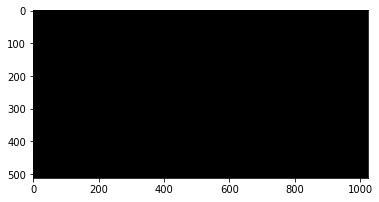

In [ ]:
print(sample.shape)
plt.imshow(sample[1])

In [ ]:
import math

# Create a new simulation dataset for testing
test_dataset = SimDataset(3, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=0)

# Get the first batch
inputs, labels = next(iter(test_loader))
print('inputs.shape', inputs.shape)
print('labels.shape', labels.shape)
testd = []
for i in inputs:
  print(i.shape)
  testd.append(reverse_transform2(i))
test1 = tf.data.Dataset.from_tensor_slices((testd))
test1 = test1.batch(9)
# Predict
pred = model.predict(test1)
# The loss functions include the sigmoid function.
print('pred.shape', pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.transpose([1,2,0]) for x in inputs.numpy()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [x.transpose([1,2,0]) for x in labels.numpy()]
pred_rgb = [x.transpose([2,0,1]) for x in pred]

inputs.shape torch.Size([5, 3, 512, 1024])
labels.shape torch.Size([5, 2, 512, 1024])
torch.Size([3, 512, 1024])
torch.Size([3, 512, 1024])
torch.Size([3, 512, 1024])
torch.Size([3, 512, 1024])
torch.Size([3, 512, 1024])
pred.shape (5, 512, 1024, 2)


In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def convert_result(mdata):
  mask2 = np.zeros((mdata.shape[0], mdata.shape[2], mdata.shape[3],3))
  for i, image in enumerate(mdata):
    mat1 = (mdata[i,0,:,:]==1)
    mat2 = (mdata[i,1,:,:]==1)
    for k in range(mat1.shape[0]):
      for l in range(mat1.shape[1]):
        if mat1[k,l]:
          mask2[i,k,l] = np.array([255,255,255])
        else:
          mask2[i,k,l] = np.array([0, 0 ,0])
        if mat2[k,l]:
          mask2[i,k,l] = np.array([216, 67, 82])
  return mask2/255

In [ ]:
pred = pred.argmax(axis=1)

In [ ]:
plot_side_by_side([pred_rgb])

In [ ]:
plot_side_by_side([input_images_rgb, 
                   convert_mask(np.array(target_masks_rgb).transpose([0,3,1,2])),
                   convert_mask(np.array(pred_rgb).transpose([0,3,1,2]))])

## Validación


In [ ]:
loss, precision, recall, accuracy, jaccard = model.evaluate(val1,verbose=1)

8/8 [==============================] - 6s 694ms/step - loss: 0.0474 - Precision: 0.1058 - Recall: 0.8376 - accuracy: 0.9795 - jaccard_distance: 0.9909


In [ ]:
loss

0.04740138351917267

In [ ]:
recall

0.837620735168457

In [ ]:
precision

0.10580451041460037

In [ ]:
accuracy

0.9794889688491821

In [ ]:
jaccard

0.9908592700958252